# Preprocess Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

"""
2Yr T-Note Tickers: TU
5Yr T-Note Tickers: FV
10Yr T-Note Tickers: TY
"""
ticker = 'TU'
data = pd.read_csv(f'{ticker}.csv', index_col=0, parse_dates=True)
data = data.drop(data.filter(regex='_Contract$').columns, axis=1)

# contracts = ['Front', f'{ticker}1', f'{ticker}2', f'{ticker}3', f'{ticker}4', f'{ticker}5', f'{ticker}6']
contracts = ['Front', f'{ticker}1']
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'OI']

for i in range(len(contracts) - 1):
    data[f'{contracts[i]}_{contracts[i+1]}_Open_Spread'] = data[f'{contracts[i]}_Open'] - data[f'{contracts[i+1]}_Open']
    data[f'{contracts[i]}_{contracts[i+1]}_Close_Spread'] = data[f'{contracts[i]}_Close'] - data[f'{contracts[i+1]}_Close']

for contract in contracts:
    temp = data.copy()
    temp['TR1'] = data[f'{contract}_High'] - data[f'{contract}_Low']
    temp['TR2'] = np.abs(data[f'{contract}_High'] - data[f'{contract}_Close'].shift(1))
    temp['TR3'] = np.abs(data[f'{contract}_Low'] - data[f'{contract}_Close'].shift(1))
    data[f'{contract}_TR'] = temp[['TR1', 'TR2', 'TR3']].max(axis=1)

    for column in ['Open', 'High', 'Low', 'Close']:
        data = data.drop(columns=[f'{contract}_{column}'])

data['Day'] = data.index.weekday
data['Week'] = data.index.isocalendar().week.tolist()
data['Month'] = data.index.month
data['Year'] = data.index.year

data.columns.tolist()

['Front_Volume',
 'Front_OI',
 'TU1_Volume',
 'TU1_OI',
 'Front_TU1_Open_Spread',
 'Front_TU1_Close_Spread',
 'Front_TR',
 'TU1_TR',
 'Day',
 'Week',
 'Month',
 'Year']

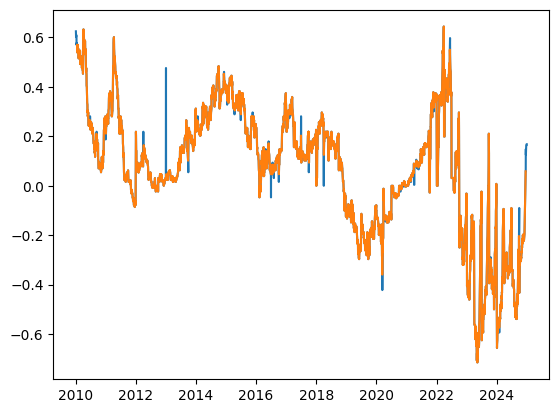

In [ ]:
def remove_outliers_rolling_zscore(df, column, window=20, threshold=2):
    rolling_mean = df[column].rolling(window=window, center=True).mean()
    rolling_std = df[column].rolling(window=window, center=True).std()
    z_scores = np.abs((df[column] - rolling_mean) / rolling_std)

    # Create mask for non-outliers
    mask = z_scores <= threshold
    return df[mask].copy()

cleaned_data = remove_outliers_rolling_zscore(data, f'Front_{ticker}1_Close_Spread')
plt.plot(data.index, data[f'Front_{ticker}1_Close_Spread'])
plt.plot(cleaned_data.index, cleaned_data[f'Front_{ticker}1_Close_Spread'])

# Get Features and Labels

In [ ]:
horizons = [1, 5, 10, 20, 40]

labels = data[f'Front_{ticker}1_Close_Spread']
for horizon in horizons:
    data[f'Label_{horizon}'] = labels.shift(-horizon)
features = data.columns.tolist()
for horizon in horizons:
    features.remove(f'Label_{horizon}')
data = data.dropna()

cleaned_labels = cleaned_data[f'Front_{ticker}1_Close_Spread']
for horizon in horizons:
    cleaned_data[f'Label_{horizon}'] = cleaned_labels.shift(-horizon)
cleaned_features = cleaned_data.columns.tolist()
for horizon in horizons:
    cleaned_features.remove(f'Label_{horizon}')
cleaned_data = cleaned_data.dropna()

# Fundamental ML Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

combined_vs_non = {}

train_sizes = [0.6, 0.7, 0.8, 0.9]

for train_size in train_sizes:
    ratio_str = str(int(train_size * 100)) + "/" + str(int(100 - train_size * 100))
    print(f"Train Size: {ratio_str}")

    for horizon in horizons:
        print(f"Horizon: {horizon}")
        s = 's' if horizon > 1 else ''
        temp_data = data.copy()
        # temp_data = temp_data.iloc[-315:]

        X = temp_data[features]
        y = temp_data[f'Label_{horizon}'].values.reshape(-1, 1) # Reshape y for scaling

        # Scale the data
        X_scaler = StandardScaler()
        X_scaled = X_scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

        y_scaler = StandardScaler()
        y_scaled = y_scaler.fit_transform(y)
        y_scaled = pd.DataFrame(y_scaled, columns=['Label'], index=X.index)

        size = int(len(temp_data) * train_size)
        X_train, X_test = X_scaled[:size], X_scaled[size:]
        y_train, y_test = y_scaled[:size], y_scaled[size:]

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=1 - train_size, random_state=42)

        # Cleaned
        cleaned_temp_data = cleaned_data.copy()
        # temp_data = temp_data.iloc[-315:]

        cleaned_X = cleaned_temp_data[cleaned_features]
        cleaned_y = cleaned_temp_data[f'Label_{horizon}'].values.reshape(-1, 1) # Reshape y for scaling

        # Scale the data
        cleaned_X_scaler = StandardScaler()
        cleaned_X_scaled = cleaned_X_scaler.fit_transform(cleaned_X)
        cleaned_X_scaled = pd.DataFrame(cleaned_X_scaled, columns=cleaned_features, index=cleaned_X.index)

        cleaned_y_scaler = StandardScaler()
        cleaned_y_scaled = cleaned_y_scaler.fit_transform(cleaned_y)
        cleaned_y_scaled = pd.DataFrame(cleaned_y_scaled, columns=['Label'], index=cleaned_X.index)

        cleaned_size = int(len(cleaned_temp_data) * train_size)
        cleaned_X_train, cleaned_X_test = cleaned_X_scaled[:cleaned_size], cleaned_X_scaled[cleaned_size:]
        cleaned_y_train, cleaned_y_test = cleaned_y_scaled[:cleaned_size], cleaned_y_scaled[cleaned_size:]

        cleaned_X_train, cleaned_X_test, cleaned_y_train, cleaned_y_test = train_test_split(cleaned_X_scaled, cleaned_y_scaled, test_size=1 - train_size, random_state=42)


        # Initialize and train the models
        models = {
            "Random Forest Regression": RandomForestRegressor(n_estimators=100, random_state=42),
            "Gradient Boosting Regression": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
            "Multilayer Perceptron Regression": MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter=500),
            "XGBoost Regression": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
            "Ridge Regression": Ridge(alpha=1.0),
            "Lasso Regression": Lasso(alpha=1.0)
        }

        cleaned_models = {
            "Cleaned Random Forest Regression": RandomForestRegressor(n_estimators=100, random_state=42),
            "Cleaned Gradient Boosting Regression": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
            "Cleaned Multilayer Perceptron Regression": MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter=500),
            "Cleaned XGBoost Regression": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
            "Cleaned Ridge Regression": Ridge(alpha=1.0),
            "Cleaned Lasso Regression": Lasso(alpha=1.0)
        }

        results = {}

        for (name, model), (cleaned_name, cleaned_model) in zip(models.items(), cleaned_models.items()):
            print(f"{name}:")

            # print(f"Training {name}...")
            model.fit(X_train, y_train.values.ravel()) # .ravel() is needed for some models

            # Predict on the test set (scaled data)
            # print(f"Predicting with {name}...")
            y_pred_scaled = model.predict(X_test)

            # Ensure the prediction output is 2D for inverse transformation if needed
            if y_pred_scaled.ndim == 1:
                y_pred_scaled = y_pred_scaled.reshape(-1, 1)

            # Inverse transform predictions and actual values
            y_pred = y_scaler.inverse_transform(y_pred_scaled)
            y_test_original = y_scaler.inverse_transform(y_test)

            # Evaluation of all sample (train and test)
            y_train_pred = model.predict(X_train)
            rmse_combined = root_mean_squared_error(y_train, y_train_pred)
            r2_combined = r2_score(y_train, y_train_pred)

            rmse = root_mean_squared_error(y_test_original, y_pred)
            r2 = r2_score(y_test_original, y_pred)

            results[name] = (y_pred, rmse, r2)

            print(f"{cleaned_name}:")
            print("Combined Root Mean Squared Error (RMSE):", rmse_combined)
            print("Combined R-squared (R2):", r2_combined)
            print("Root Mean Squared Error (RMSE):", rmse)
            print("R-squared (R2):", r2)

            # Cleaned
            # print(f"Cleaned Training {cleaned_name}...")
            cleaned_model.fit(cleaned_X_train, cleaned_y_train.values.ravel()) # .ravel() is needed for some models

            # Predict on the test set (scaled data)
            # print(f"Cleaned Predicting with {cleaned_name}...")
            cleaned_y_pred_scaled = cleaned_model.predict(cleaned_X_test)

            # Ensure the prediction output is 2D for inverse transformation if needed
            if cleaned_y_pred_scaled.ndim == 1:
                cleaned_y_pred_scaled = cleaned_y_pred_scaled.reshape(-1, 1)

            # Inverse transform predictions and actual values
            cleaned_y_pred = cleaned_y_scaler.inverse_transform(cleaned_y_pred_scaled)
            cleaned_y_test_original = cleaned_y_scaler.inverse_transform(cleaned_y_test)

            # Evaluation of all sample (train and test)
            cleaned_y_train_pred = model.predict(cleaned_X_train)
            cleaned_rmse_combined = root_mean_squared_error(cleaned_y_train, cleaned_y_train_pred)
            cleaned_r2_combined = r2_score(cleaned_y_train, cleaned_y_train_pred)

            cleaned_rmse = root_mean_squared_error(cleaned_y_test_original, cleaned_y_pred)
            cleaned_r2 = r2_score(cleaned_y_test_original, cleaned_y_pred)

            results[cleaned_name] = (cleaned_y_pred, cleaned_rmse, cleaned_r2)

            print(f"{cleaned_name}:")
            print("Combined Cleaned Root Mean Squared Error (RMSE):", cleaned_rmse_combined)
            print("Combined Cleaned R-squared (R2):", cleaned_r2_combined)
            print("Cleaned Root Mean Squared Error (RMSE):", cleaned_rmse)
            print("Cleaned R-squared (R2):", cleaned_r2)

            combined_vs_non[f'{ratio_str} {name} {horizon}'] = (name, ratio_str, horizon, rmse, rmse_combined, r2, r2_combined, cleaned_rmse, cleaned_rmse_combined, cleaned_r2, cleaned_r2_combined)

            # plt.figure(figsize=(10, 4)) # Create a new figure

            # # Visualization - Actual vs Predicted (Original Scale)
            # plt.subplot(1, 2, 1)
            # plt.scatter(y_test_original, y_pred, alpha=0.5)
            # plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
            # plt.xlabel(f"Actual Difference {horizon} day{s}")
            # plt.ylabel(f"Predicted Difference {horizon} day{s}")
            # plt.title(f"{name} - Actual vs Predicted (Original Scale)")

            # # Test vs prediction plot (Original Scale)
            # sorted_index = sorted(y_test.index)

            # y_dict_original = {}
            # y_dict_pred = {}
            # for i, date in enumerate(y_test.index):
            #     y_dict_original[date] = y_test_original[i]
            #     y_dict_pred[date] = y_pred[i]

            # y_new_original = []
            # y_new_pred = []
            # for date in sorted_index:
            #     y_new_original.append(y_dict_original[date])
            #     y_new_pred.append(y_dict_pred[date])

            # plt.subplot(1, 2, 2)
            # plt.plot(sorted_index, y_new_original, label=f'Actual {horizon} day{s}', color='blue')
            # plt.plot(sorted_index, y_new_pred, label=f'Predicted {horizon} day{s}', color='red', linestyle='--')
            # plt.xlabel("Date")
            # plt.ylabel(f"Difference {horizon} days")
            # plt.title(f"{name} - Test vs Prediction (Original Scale)")
            # plt.legend()

            # plt.tight_layout()
            # plt.show()

            # plt.figure(figsize=(10, 6))
            # plt.plot(y_test.index, y_test_original, label='Actual', color='blue')
            # plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--')
            # plt.xlabel("Date")
            # plt.ylabel("Difference")
            # plt.title(f"{name} - Test vs Prediction (Original Scale)")
            # plt.legend()
            # plt.show()
            print()

        print()
        print()
        print()

Train Size: 60/40
Horizon: 1
Random Forest Regression:
Cleaned Random Forest Regression:
Combined Root Mean Squared Error (RMSE): 0.05725232079904338
Combined R-squared (R2): 0.9967753028453116
Root Mean Squared Error (RMSE): 0.031742236047736565
R-squared (R2): 0.983544199540573
Cleaned Random Forest Regression:
Combined Cleaned Root Mean Squared Error (RMSE): 0.11462381300649765
Combined Cleaned R-squared (R2): 0.9867081744985027
Cleaned Root Mean Squared Error (RMSE): 0.02731913695294354
Cleaned R-squared (R2): 0.9882212030358847

Gradient Boosting Regression:
Cleaned Gradient Boosting Regression:
Combined Root Mean Squared Error (RMSE): 0.08173317161775324
Combined R-squared (R2): 0.9934279713815158
Root Mean Squared Error (RMSE): 0.030891281785457924
R-squared (R2): 0.9844146759408458
Cleaned Gradient Boosting Regression:
Combined Cleaned Root Mean Squared Error (RMSE): 0.16231128138112477
Combined Cleaned R-squared (R2): 0.9733478443371139
Cleaned Root Mean Squared Error (RMSE): 

In [8]:
(rmse, rmse_combined, r2, r2_combined, cleaned_rmse, cleaned_rmse_combined, cleaned_r2, cleaned_r2_combined)

combined_vs_non_df = pd.DataFrame.from_dict(combined_vs_non, orient='index', columns=['Model', 'Ratio', 'Horizon', 'Test RMSE', f'Training RMSE', 'Test R2', f'Training R2', 'Cleaned Test RMSE', f'Cleaned Training RMSE', 'Cleaned Test R2', f'Cleaned Training R2'])
# make model, ratio, horizon indexes, and remove original index
combined_vs_non_df = combined_vs_non_df.reset_index()
combined_vs_non_df = combined_vs_non_df.set_index(['Model', 'Ratio', 'Horizon'])
# remove index
combined_vs_non_df = combined_vs_non_df.drop(columns=['index'])
# remove cleaned
combined_vs_non_df = combined_vs_non_df.drop(columns=['Cleaned Test RMSE', 'Cleaned Training RMSE', 'Cleaned Test R2', 'Cleaned Training R2'])
combined_vs_non_df.to_csv(f'RMSE_R2_Test_Split_{ticker}.csv')
combined_vs_non_df

,,,Test RMSE,Training RMSE,Test R2,Training R2
Model,Ratio,Horizon,,,,
Random Forest Regression,60/40,1,0.031742,0.057252,0.983544,0.996775
Gradient Boosting Regression,60/40,1,0.030891,0.081733,0.984415,0.993428
Multilayer Perceptron Regression,60/40,1,0.031871,0.130993,0.983411,0.983119
XGBoost Regression,60/40,1,0.031295,0.055467,0.984005,0.996973
Ridge Regression,60/40,1,0.030901,0.137693,0.984405,0.981348
...,...,...,...,...,...,...
Gradient Boosting Regression,90/10,40,0.084548,0.289690,0.895790,0.914884
Multilayer Perceptron Regression,90/10,40,0.094041,0.283505,0.871076,0.918479
XGBoost Regression,90/10,40,0.054727,0.148628,0.956337,0.977595


# Complex LSTM Model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5025 - val_loss: 0.2595
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2728 - val_loss: 0.2500
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2608 - val_loss: 0.2458
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2566 - val_loss: 0.2618
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2721 - val_loss: 0.2618
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2796 - val_loss: 0.2381
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2693 - val_loss: 0.2480
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2565 - val_loss: 0.2258
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2608 - val_loss: 0.2418
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2569 - val_loss: 0.2207
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2511 - val_loss: 0.2284
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2286 - val_l

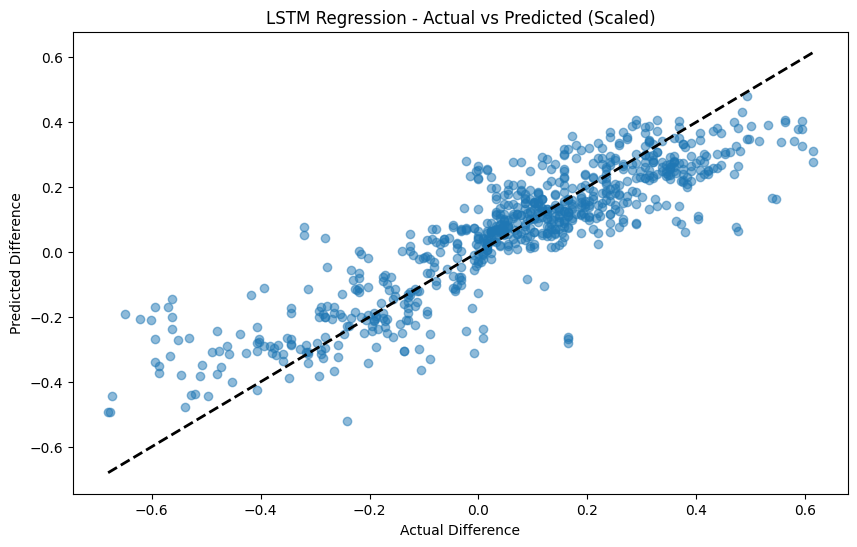


LSTM Regression - Test vs Prediction (Original Scale)


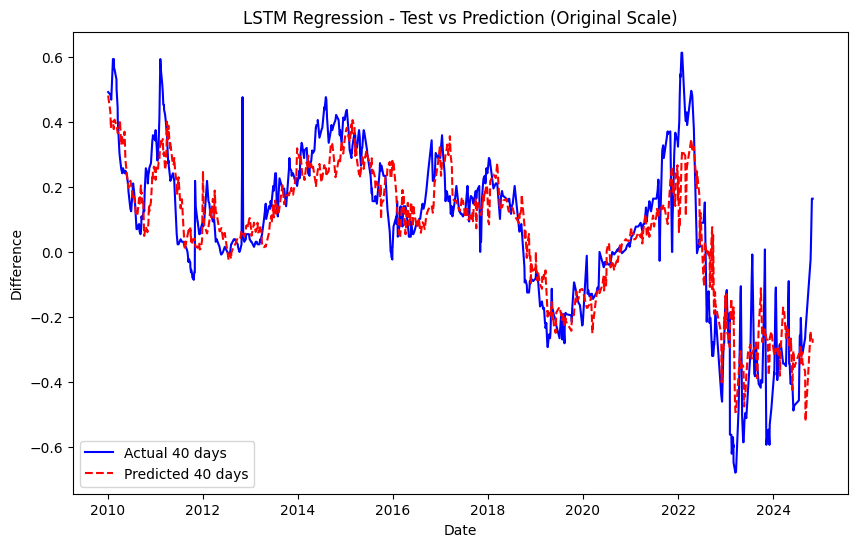

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

X_train, X_test = X_scaled[:size], X_scaled[size:]
y_train, y_test = y_scaled[:size], y_scaled[size:]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape data for LSTM (samples, time steps, features)
time_steps = 3 # You can adjust this based on your analysis
n_features = X_train.shape[1]
# Ensure that the number of features is divisible by time_steps or adjust time_steps
if n_features % time_steps != 0:
    # Option 1: Adjust time_steps (simplest for demonstration)
    # Find the largest divisor of n_features less than or equal to the desired time_steps
    for ts in range(time_steps, 0, -1):
        if n_features % ts == 0:
            time_steps = ts
            break
    if n_features % time_steps != 0:
         raise ValueError(f"Number of features ({n_features}) is not divisible by the chosen time_steps ({time_steps}). Please choose a different time_steps value.")


X_train_lstm = X_train.values.reshape(X_train.shape[0], time_steps, n_features // time_steps)
X_test_lstm = X_test.values.reshape(X_test.shape[0], time_steps, n_features // time_steps)


# Define the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Flatten()) # Flatten the output of the LSTM layer
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(Dense(1)) # Output layer for regression


# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Predict
y_pred_lstm_scaled = model.predict(X_test_lstm)

# Ensure the prediction output is 2D for inverse transformation
y_pred_lstm_scaled = y_pred_lstm_scaled.reshape(-1, 1)

# Inverse transform predictions and actual values
y_pred_lstm = y_scaler.inverse_transform(y_pred_lstm_scaled)
y_test_original = y_scaler.inverse_transform(y_test)

# Evaluation
rmse_lstm = root_mean_squared_error(y_test_original, y_pred_lstm)
r2_lstm = r2_score(y_test_original, y_pred_lstm)
print("\nLSTM Regression:")
print("Root Mean Squared Error (RMSE):", rmse_lstm)
print("R-squared (R2):", r2_lstm)

# Visualization
print("\nLSTM Regression - Actual vs Predicted (Scaled)")
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_lstm, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.xlabel("Actual Difference")
plt.ylabel("Predicted Difference")
plt.title("LSTM Regression - Actual vs Predicted (Scaled)")
plt.show()

# Test vs prediction plot (Original Scale)
sorted_index = sorted(y_test.index)

y_dict_original = {}
y_dict_pred = {}
for i, date in enumerate(y_test.index):
    y_dict_original[date] = y_test_original[i]
    y_dict_pred[date] = y_pred_lstm[i]

y_new_original = []
y_new_pred = []
for date in sorted_index:
    y_new_original.append(y_dict_original[date])
    y_new_pred.append(y_dict_pred[date])

print("\nLSTM Regression - Test vs Prediction (Original Scale)")
plt.figure(figsize=(10, 6))
plt.plot(sorted_index, y_new_original, label=f'Actual {horizon} day{s}', color='blue')
plt.plot(sorted_index, y_new_pred, label=f'Predicted {horizon} day{s}', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Difference")
plt.title("LSTM Regression - Test vs Prediction (Original Scale)")
plt.legend()
plt.show()